 # Prediction Performance and Interpretability Assessment of Latent Feature Based Methods

 ## Module Imports

In [1]:
from typing import List, Literal, Generator, Tuple, Callable, Dict, Any
import math
import logging
import anndata as ad
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from numpy import intp, number, str_
import polars as pl
import scanpy as sc
from tqdm import tqdm
from anndata.typing import AnnData
import nico2_lib as n2l
from joblib import Memory
import seaborn as sns
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from nico2_lib.predictors._nn_models._nn_pred import FullyLinearVaePredictor


In [2]:
reference = n2l.dt.small_mouse_intestine_sc("./data")


 ## Environment Variables

In [3]:
DATA_DIR: str = "./data"
CACHE_DIR: str = "./cache"
SEED: int = 0
if not logging.getLogger().handlers:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    )
logger = logging.getLogger(__name__)



 ## Helper Functions

In [4]:
memory = Memory(CACHE_DIR)


def _adata_dense_mut(adata: AnnData) -> None:
    if hasattr(adata.X, "toarray"):  # type: ignore
        logger.debug("Densifying AnnData.X with shape=%s", adata.X.shape)
        adata.X = adata.X.toarray()  # type: ignore


def _create_spatial_loader(
    query_loader: Callable[[str], AnnData],
    query_ct_key: str,
    reference_loader: Callable[[str], AnnData],
    reference_ct_key: str,
) -> Callable[..., Tuple[AnnData, AnnData, str, str]]:
    """Create a spatial query–reference dataset loader.

    The returned loader loads query and reference AnnData objects, densifies them,
    performs label transfer from the reference to the query, and returns a
    standardized (query, reference, cell-type keys) tuple.

    Args:
        query_loader: Function that loads the spatial query AnnData.
        query_ct_key: Cell type column name to store predictions in the query.
        reference_loader: Function that loads the reference AnnData.
        reference_ct_key: Cell type column name in the reference.

    Returns:
        A loader function mapping a data directory to
        (query, reference, query_ct_key, reference_ct_key). The loader accepts a
        cached_label_transfer flag to enable/disable on-disk caching.
    """

    logger.info(
        "Creating spatial loader with query_ct_key=%s reference_ct_key=%s",
        query_ct_key,
        reference_ct_key,
    )

    def loader(
        dir: str,
    ) -> Tuple[AnnData, AnnData, str, str]:
        logger.info("Loading spatial dataset from dir=%s", dir)
        query = query_loader(dir)
        reference = reference_loader(dir)
        logger.debug(
            "Loaded spatial AnnData query_shape=%s reference_shape=%s",
            query.shape,
            reference.shape,
        )

        _adata_dense_mut(query)
        _adata_dense_mut(reference)

        query.obs[query_ct_key] = memory.cache(n2l.lt.scvi_transfer)(
            query,
            reference,
            reference_ct_key,
        )
        shared_features = np.intersect1d(query.var_names, reference.var_names)
        logger.info(
            "Spatial loader complete: shared_features=%d query_cells=%d reference_cells=%d",
            shared_features.shape[0],
            query.n_obs,
            reference.n_obs,
        )
        return (
            query[:, shared_features],
            reference[:, shared_features],
            query_ct_key,
            reference_ct_key,
        )

    return loader


def _create_pseudospatial_loader(
    loader_func: Callable[[str], AnnData],
    ct_key: str,
    seed: int,
) -> Callable[..., Tuple[AnnData, AnnData, str, str]]:
    """Create a pseudospatial query–reference dataset loader.

    The returned loader randomly splits a single AnnData object into query and
    reference halves. The query is restricted to the top 500 highly variable genes.

    Args:
        loader_func: Function that loads a single AnnData object.
        ct_key: Cell type column name shared by query and reference.
        seed: for deterministic split

    Returns:
        A loader function mapping a data directory to
        (query, reference, ct_key, ct_key).
    """

    logger.info("Creating pseudospatial loader with ct_key=%s seed=%d", ct_key, seed)

    def split_loader(
        dir: str,
    ) -> Tuple[AnnData, AnnData, str, str]:
        logger.info("Loading pseudospatial dataset from dir=%s", dir)
        rng = np.random.default_rng(seed)
        adata = loader_func(dir)
        n_cells = adata.n_obs
        shuffled_idx = rng.permutation(n_cells)
        split_idx = n_cells // 2

        idx1, idx2 = shuffled_idx[:split_idx], shuffled_idx[split_idx:]
        query = adata[idx1].copy()
        reference = adata[idx2].copy()
        logger.debug(
            "Pseudospatial split complete: total_cells=%d query_cells=%d reference_cells=%d",
            n_cells,
            query.n_obs,
            reference.n_obs,
        )

        sc.pp.highly_variable_genes(
            query, n_top_genes=500, flavor="seurat_v3", inplace=True
        )
        query = query[:, query.var["highly_variable"]].copy()
        logger.info(
            "Pseudospatial loader complete: query_shape=%s reference_shape=%s",
            query.shape,
            reference.shape,
        )

        return query, reference, ct_key, ct_key

    return split_loader



 ### Dataloaders

In [5]:
@memory.cache
def dataset_generator() -> Generator[
    Tuple[Tuple[AnnData, AnnData, str, str], Dict[str, Any]], None, None
]:
    logger.info("Creating dataset generator")
    dataloader_dict = {
        "small_mouse_intestine_spatial": (
            _create_spatial_loader(
                n2l.dt.small_mouse_intestine_merfish,
                "cluster",
                n2l.dt.small_mouse_intestine_sc,
                "cluster",
            ),
            {"organism": "mouse", "dataset_type": "spatial"},
        ),
        "small_mouse_intestine_pseudospatial": (
            _create_pseudospatial_loader(
                n2l.dt.small_mouse_intestine_sc, "cluster", seed=SEED
            ),
            {"organism": "mouse", "dataset_type": "pseudospatial"},
        ),
    }
    for dataset_name, dataset in dataloader_dict.items():
        data_loader, metadata = dataset
        logger.info("Yielding dataset=%s metadata=%s", dataset_name, metadata)
        yield data_loader(DATA_DIR), {**{"dataset_name": dataset_name}, **metadata}



 ### Predictors

In [6]:
def predictor_generator():
    logger.info("Creating predictor generator")
    predictor_registry = [
        (n2l.pd.NmfPredictor, {"n_components": 3}, {"predictor_name": "nmf_3"}),
        (n2l.pd.NmfPredictor, {"n_components": 8}, {"predictor_name": "nmf_8"}),
    ]
    for predictor, kwargs, metadata in predictor_registry:
        logger.info(
            "Yielding predictor=%s predictor_name=%s kwargs=%s",
            predictor.__name__,
            metadata["predictor_name"],
            kwargs,
        )
        yield predictor(**kwargs), {**kwargs, **metadata}



 ### Experiment

In [7]:
def _sample_indices(
    total_features: int, n_samples: int, sample_size: int, rng: np.random.Generator
):
    logger.debug(
        "Sampling indices total_features=%d n_samples=%d sample_size=%d",
        total_features,
        n_samples,
        sample_size,
    )
    if sample_size < 0 or sample_size > total_features:
        raise ValueError(
            f"sample_size must be in [0, total_features], got {sample_size} for {total_features}"
        )
    indices = np.vstack([rng.permutation(total_features) for _ in range(n_samples)])
    train_idx, test_idx = np.split(indices, [sample_size], axis=1)
    logger.debug(
        "Sampled indices shapes train_idx=%s test_idx=%s",
        train_idx.shape,
        test_idx.shape,
    )
    return train_idx, test_idx


@memory.cache
def run_feature_prediction_experiment(
    dataset: Tuple[AnnData, AnnData, str, str],
    predictor: n2l.pd.PredictorProtocol,
    *,
    seed: int,
    n_samples: int,
    sample_length: int,
    injected_metadata: Dict[str, Any],
) -> Dict[str, Any]:
    logger.info(
        "Starting feature prediction experiment dataset=%s predictor=%s n_samples=%d sample_length=%d seed=%d",
        injected_metadata.get("dataset_name"),
        injected_metadata.get("predictor_name"),
        n_samples,
        sample_length,
        seed,
    )
    query, reference, query_ct_key, reference_ct_key = dataset
    _adata_dense_mut(query)
    _adata_dense_mut(reference)
    shared_features = np.intersect1d(query.var_names, reference.var_names)
    n_features = shared_features.shape[0]
    rng = np.random.default_rng(seed)
    train_idxs, test_idxs = _sample_indices(n_features, n_samples, sample_length, rng)

    query_celltypes = query.obs[query_ct_key].to_numpy()
    reference_celltypes = reference.obs[reference_ct_key].to_numpy()
    shared_celltypes = np.intersect1d(query_celltypes, reference_celltypes)
    query_shared = query[
        query.obs[query_ct_key].isin(shared_celltypes), shared_features
    ]
    reference_shared = reference[
        reference.obs[reference_ct_key].isin(shared_celltypes), shared_features
    ]
    logger.info(
        "Prepared shared dataset: shared_features=%d shared_celltypes=%d query_shared_shape=%s reference_shared_shape=%s",
        shared_features.shape[0],
        shared_celltypes.shape[0],
        query_shared.shape,
        reference_shared.shape,
    )

    run_metadata = {
        **injected_metadata,
        "seed": seed,
        "n_samples": n_samples,
        "sample_length": sample_length,
    }
    shared_metadata = {
        "query_counts": query_shared.X,
        "obs_names": query_shared.obs_names.to_numpy(copy=False),
        "celltypes": query_shared.obs[query_ct_key].to_numpy(),
        "train_idxs": train_idxs,
        "test_idxs": test_idxs,
    }
    samples = []
    model = predictor.fit(reference_shared.X)
    model_metadata = {
        "prediction_scope": "global",
    }
    for sample_idx, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
        logger.debug(
            "Running global prediction sample_idx=%d train_features=%d test_features=%d",
            sample_idx,
            train_idx.shape[0],
            test_idx.shape[0],
        )
        embedding, prediction = model.predict(query_shared[:, train_idx].X, train_idx)
        sample_metadata = {
            "query_reconstruction": prediction,
            "embedding": embedding,
            "sample_idx": sample_idx,
        }
        samples.append({**model_metadata, **sample_metadata})

    celltype_models = []
    query_shared_celltypes = query_shared.obs[query_ct_key].to_numpy()
    reference_shared_celltypes = reference_shared.obs[reference_ct_key].to_numpy()
    for celltype in shared_celltypes:
        reference_celltype_mask = reference_shared_celltypes == celltype
        query_celltype_mask = query_shared_celltypes == celltype
        reference_shared_celltype = reference_shared[reference_celltype_mask]
        query_shared_celltype = query_shared[query_celltype_mask]
        model = predictor.fit(reference_shared_celltype.X)
        query_row_indices = np.flatnonzero(query_celltype_mask)
        celltype_models.append(
            (celltype, model, query_shared_celltype, query_row_indices)
        )
    logger.info("Trained %d celltype-specific models", len(celltype_models))

    if celltype_models:
        model_metadata = {"prediction_scope": "celltype"}
        for sample_idx, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
            logger.debug(
                "Running celltype prediction sample_idx=%d train_features=%d test_features=%d",
                sample_idx,
                train_idx.shape[0],
                test_idx.shape[0],
            )
            embedding_parts = []
            reconstruction_parts = []
            query_row_indices_parts = []
            for _, model, query_shared_celltype, query_row_indices in celltype_models:
                embedding, prediction = model.predict(
                    query_shared_celltype[:, train_idx].X, train_idx
                )
                embedding_parts.append(embedding)
                reconstruction_parts.append(prediction)
                query_row_indices_parts.append(query_row_indices)

            ordered_idx = np.argsort(np.concatenate(query_row_indices_parts))
            embedding = np.concatenate(embedding_parts, axis=0)[ordered_idx]
            query_reconstruction = np.concatenate(reconstruction_parts, axis=0)[
                ordered_idx
            ]
            sample_metadata = {
                "query_reconstruction": query_reconstruction,
                "embedding": embedding,
                "sample_idx": sample_idx,
            }
            samples.append({**model_metadata, **sample_metadata})

    logger.info(
        "Completed feature prediction experiment dataset=%s predictor=%s total_results=%d",
        injected_metadata.get("dataset_name"),
        injected_metadata.get("predictor_name"),
        len(samples),
    )
    return {
        "run_metadata": run_metadata,
        "shared": shared_metadata,
        "samples": samples,
    }



 ### Scoring

In [8]:
@memory.cache
def compute_score(
    query: NDArray[number],
    query_reconstruction: NDArray[number],
    celltypes: NDArray[str_],
) -> list[Tuple[str, float, float]]:
    """
    Computes weighted and macro averages for each hardcoded metric.
    Returns a list of (metric_name, weighted, macro).
    """
    logger.info(
        "Computing scores query_shape=%s reconstruction_shape=%s n_celltypes=%d",
        query.shape,
        query_reconstruction.shape,
        celltypes.shape[0],
    )
    if query.shape[0] != query_reconstruction.shape[0]:
        raise ValueError(
            f"query and query_reconstruction must have same n (axis 0): "
            f"{query.shape[0]} != {query_reconstruction.shape[0]}"
        )
    if query.shape[0] != celltypes.shape[0]:
        raise ValueError(
            f"celltypes length must match n (axis 0): {celltypes.shape[0]} != {query.shape[0]}"
        )

    metric_funcs: list[
        Tuple[str, Callable[[NDArray[number], NDArray[number]], float]]
    ] = [
        ("pearson", aggregate_score(n2l.mt.pearson_metric)),
        ("mse", aggregate_score(n2l.mt.mse_metric)),
        ("spearman", aggregate_score(n2l.mt.spearman_metric)),
        ("cosine", aggregate_score(n2l.mt.cosine_similarity_metric)),
        ("explaind_var", aggregate_score(n2l.mt.explained_variance_metric)),
        ("explained_var_v2", aggregate_score(n2l.mt.explained_variance_metric_v2)),
    ]

    metric_results: list[Tuple[str, float, float]] = []
    unique_celltypes = np.unique(celltypes)

    for metric_name, metric_func in metric_funcs:
        scores: list[float] = []
        weights: list[int] = []

        for ct in unique_celltypes:
            mask = celltypes == ct
            n = int(mask.sum())
            if n == 0:
                continue
            scores.append(float(metric_func(query[mask], query_reconstruction[mask])))
            weights.append(n)

        if not scores:
            raise ValueError("No celltypes found to score (empty input).")

        macro = float(np.mean(scores))
        weighted = float(np.average(scores, weights=weights))
        metric_results.append((metric_name, weighted, macro))
        logger.debug(
            "Computed metric=%s weighted=%.6f macro=%.6f",
            metric_name,
            weighted,
            macro,
        )

    logger.info("Completed score computation for %d metrics", len(metric_results))
    return metric_results


def aggregate_score(
    score_func: Callable[[NDArray[number], NDArray[number]], float],
    agg_func: Callable[[NDArray[number], NDArray[number]], float] = np.mean,
    axis: int = 0,
) -> float:
    logger.debug("Creating aggregate score function axis=%d", axis)

    def inner_func(
        x: NDArray[number],
        y: NDArray[number],
    ) -> float:
        logger.debug("Aggregating score with x_shape=%s y_shape=%s", x.shape, y.shape)
        x_m = np.moveaxis(x, axis, 0)
        y_m = np.moveaxis(y, axis, 0)

        scores = np.array([score_func(a, b) for a, b in zip(x_m, y_m)], dtype=float)
        scores = scores[~np.isnan(scores)]
        return float(agg_func(scores))

    return inner_func



 ## Data Generation

In [9]:
N_SAMPLES = 2
SAMPLE_LENGTH = 20


runs = []
for (dataset, dataset_metadata), (predictor, predictor_metadata) in tqdm(
    itertools.product(dataset_generator(), predictor_generator())
):
    run = run_feature_prediction_experiment(
        dataset,
        predictor,
        seed=SEED,
        n_samples=N_SAMPLES,
        sample_length=SAMPLE_LENGTH,
        injected_metadata={**dataset_metadata, **predictor_metadata},
    )
    runs.append(run)


2026-02-11 15:52:25,770 | INFO | __main__ | Creating dataset generator
2026-02-11 15:52:25,770 | INFO | __main__ | Creating spatial loader with query_ct_key=cluster reference_ct_key=cluster
2026-02-11 15:52:25,770 | INFO | __main__ | Creating pseudospatial loader with ct_key=cluster seed=0
2026-02-11 15:52:25,770 | INFO | __main__ | Yielding dataset=small_mouse_intestine_spatial metadata={'organism': 'mouse', 'dataset_type': 'spatial'}
2026-02-11 15:52:25,771 | INFO | __main__ | Loading spatial dataset from dir=./data


________________________________________________________________________________
[Memory] Calling __main__--var-folders-qm-v_v5_1r52bx792m7x2mh177c0000gn-T-ipykernel-3877445702.dataset_generator...
dataset_generator()
________________________________________________dataset_generator - 0.0s, 0.0min


2026-02-11 15:52:26,584 | INFO | __main__ | Spatial loader complete: shared_features=240 query_cells=7416 reference_cells=2239
2026-02-11 15:52:26,587 | INFO | __main__ | Yielding dataset=small_mouse_intestine_pseudospatial metadata={'organism': 'mouse', 'dataset_type': 'pseudospatial'}
2026-02-11 15:52:26,587 | INFO | __main__ | Loading pseudospatial dataset from dir=./data
2026-02-11 15:52:27,185 | INFO | __main__ | Pseudospatial loader complete: query_shape=(1119, 500) reference_shape=(1120, 32287)
2026-02-11 15:52:27,185 | INFO | __main__ | Creating predictor generator
2026-02-11 15:52:27,186 | INFO | __main__ | Yielding predictor=NmfPredictor predictor_name=nmf_3 kwargs={'n_components': 3}
2026-02-11 15:52:27,186 | INFO | __main__ | Yielding predictor=NmfPredictor predictor_name=nmf_8 kwargs={'n_components': 8}
3it [00:01,  2.37it/s]2026-02-11 15:52:28,840 | INFO | __main__ | Starting feature prediction experiment dataset=small_mouse_intestine_pseudospatial predictor=nmf_8 n_sampl

________________________________________________________________________________
[Memory] Calling __main__--var-folders-qm-v_v5_1r52bx792m7x2mh177c0000gn-T-ipykernel-163641583.run_feature_prediction_experiment...
run_feature_prediction_experiment(( AnnData object with n_obs × n_vars = 1119 × 500
    obs: 'cluster'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg',
  AnnData object with n_obs × n_vars = 1120 × 32287
    obs: 'cluster',
  'cluster',
  'cluster'), 
NmfPredictor(n_components=8,
             seed=0,
             solver='cd',
             h_reference=None,
             n_shared_features=None,
             ref_embedding=None), seed=0, n_samples=2, sample_length=20, injected_metadata={ 'dataset_name': 'small_mouse_intestine_pseudospatial',
  'dataset_type': 'pseudospatial',
  'n_components': 8,
  'organism': 'mouse',
  'predictor_name': 'nmf_8'})


2026-02-11 15:52:29,144 | INFO | __main__ | Trained 19 celltype-specific models
2026-02-11 15:52:29,204 | INFO | __main__ | Completed feature prediction experiment dataset=small_mouse_intestine_pseudospatial predictor=nmf_8 total_results=4
4it [00:02,  1.98it/s]

________________________________run_feature_prediction_experiment - 0.4s, 0.0min


 ## Data Visualizations

 ### Reconstruction

 #### Scores

In [10]:
for run in tqdm(runs):
    shared = run["shared"]
    query_counts = shared["query_counts"]
    test_idxs = shared["test_idxs"]
    celltypes = shared["celltypes"]
    for sample in run["samples"]:
        test_idx = test_idxs[sample["sample_idx"]]
        sample["scores"] = {
            metric_name: {"weighted": weighted, "macro": macro}
            for metric_name, weighted, macro in compute_score(
                query_counts[:, test_idx],
                sample["query_reconstruction"][:, test_idx],
                celltypes,
            )
        }

df_rows = []
for run in runs:
    run_metadata = run["run_metadata"]
    for sample in run["samples"]:
        base = {
            "dataset_name": run_metadata["dataset_name"],
            "predictor_name": run_metadata["predictor_name"],
            "prediction_scope": sample["prediction_scope"],
        }
        for aggregation_type in ("weighted", "macro"):
            row = base | {"aggregation_type": aggregation_type}
            row |= {
                metric_name: score_by_agg[aggregation_type]
                for metric_name, score_by_agg in sample["scores"].items()
            }
            df_rows.append(row)

df = pl.DataFrame(df_rows)
df


 50%|█████     | 2/4 [00:00<00:00,  8.39it/s]2026-02-11 15:52:29,517 | INFO | __main__ | Computing scores query_shape=(1119, 480) reconstruction_shape=(1119, 480) n_celltypes=1119


________________________________________________________________________________
[Memory] Calling __main__--var-folders-qm-v_v5_1r52bx792m7x2mh177c0000gn-T-ipykernel-1214953286.compute_score...
compute_score(ArrayView([[0., ..., 0.],
           ...,
           [0., ..., 0.]], shape=(1119, 480), dtype=float32), 
array([[0.278834, ..., 0.659977],
       ...,
       [0.011964, ..., 0.067865]], shape=(1119, 480), dtype=float32), 
array(['BZE', ..., 'Tuft'], shape=(1119,), dtype=object))


2026-02-11 15:52:30,059 | INFO | __main__ | Completed score computation for 6 metrics
2026-02-11 15:52:30,070 | INFO | __main__ | Computing scores query_shape=(1119, 480) reconstruction_shape=(1119, 480) n_celltypes=1119


____________________________________________________compute_score - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-qm-v_v5_1r52bx792m7x2mh177c0000gn-T-ipykernel-1214953286.compute_score...
compute_score(ArrayView([[ 0., ..., 43.],
           ...,
           [ 0., ...,  0.]], shape=(1119, 480), dtype=float32), 
array([[2.098082e-03, ..., 2.134704e+01],
       ...,
       [2.017012e-03, ..., 2.429098e-01]],
      shape=(1119, 480), dtype=float32), 
array(['BZE', ..., 'Tuft'], shape=(1119,), dtype=object))


2026-02-11 15:52:30,615 | INFO | __main__ | Completed score computation for 6 metrics
2026-02-11 15:52:30,626 | INFO | __main__ | Computing scores query_shape=(1119, 480) reconstruction_shape=(1119, 480) n_celltypes=1119


____________________________________________________compute_score - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-qm-v_v5_1r52bx792m7x2mh177c0000gn-T-ipykernel-1214953286.compute_score...
compute_score(ArrayView([[0., ..., 0.],
           ...,
           [0., ..., 0.]], shape=(1119, 480), dtype=float32), 
array([[0.022299, ..., 2.11407 ],
       ...,
       [0.      , ..., 0.025373]], shape=(1119, 480), dtype=float32), 
array(['BZE', ..., 'Tuft'], shape=(1119,), dtype=object))


2026-02-11 15:52:31,148 | INFO | __main__ | Completed score computation for 6 metrics
2026-02-11 15:52:31,160 | INFO | __main__ | Computing scores query_shape=(1119, 480) reconstruction_shape=(1119, 480) n_celltypes=1119


____________________________________________________compute_score - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-qm-v_v5_1r52bx792m7x2mh177c0000gn-T-ipykernel-1214953286.compute_score...
compute_score(ArrayView([[ 0., ..., 43.],
           ...,
           [ 0., ...,  0.]], shape=(1119, 480), dtype=float32), 
array([[1.836252e-03, ..., 2.282739e+01],
       ...,
       [0.000000e+00, ..., 0.000000e+00]],
      shape=(1119, 480), dtype=float32), 
array(['BZE', ..., 'Tuft'], shape=(1119,), dtype=object))


2026-02-11 15:52:31,698 | INFO | __main__ | Completed score computation for 6 metrics
100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

____________________________________________________compute_score - 0.5s, 0.0min


dataset_name,predictor_name,prediction_scope,aggregation_type,pearson,mse,spearman,cosine,explaind_var,explained_var_v2
str,str,str,str,f64,f64,f64,f64,f64,f64
"""small_mouse_intestine_spatial""","""nmf_3""","""global""","""weighted""",0.132732,64122.54996,0.269185,0.144687,-17465.174899,-17551.371761
"""small_mouse_intestine_spatial""","""nmf_3""","""global""","""macro""",0.135454,53304.11998,0.260775,0.144011,-14404.292801,-14475.299661
"""small_mouse_intestine_spatial""","""nmf_3""","""global""","""weighted""",0.136232,17828.310934,0.259639,0.147678,-6207.124854,-6237.258117
"""small_mouse_intestine_spatial""","""nmf_3""","""global""","""macro""",0.152972,15087.445259,0.248505,0.165136,-5135.123329,-5159.992342
"""small_mouse_intestine_spatial""","""nmf_3""","""celltype""","""weighted""",0.522697,2614.733659,0.347414,0.500775,-186.782951,-187.726931
…,…,…,…,…,…,…,…,…,…
"""small_mouse_intestine_pseudosp…","""nmf_8""","""global""","""macro""",0.226524,1.7961e6,0.303974,0.225701,-35580.472242,-36000.341522
"""small_mouse_intestine_pseudosp…","""nmf_8""","""celltype""","""weighted""",0.546301,2.7025e7,0.512654,0.497649,-1.9922e6,-2.0464e6
"""small_mouse_intestine_pseudosp…","""nmf_8""","""celltype""","""macro""",0.60891,2.6363e8,0.545639,0.536486,-1.9554e7,-2.0086e7


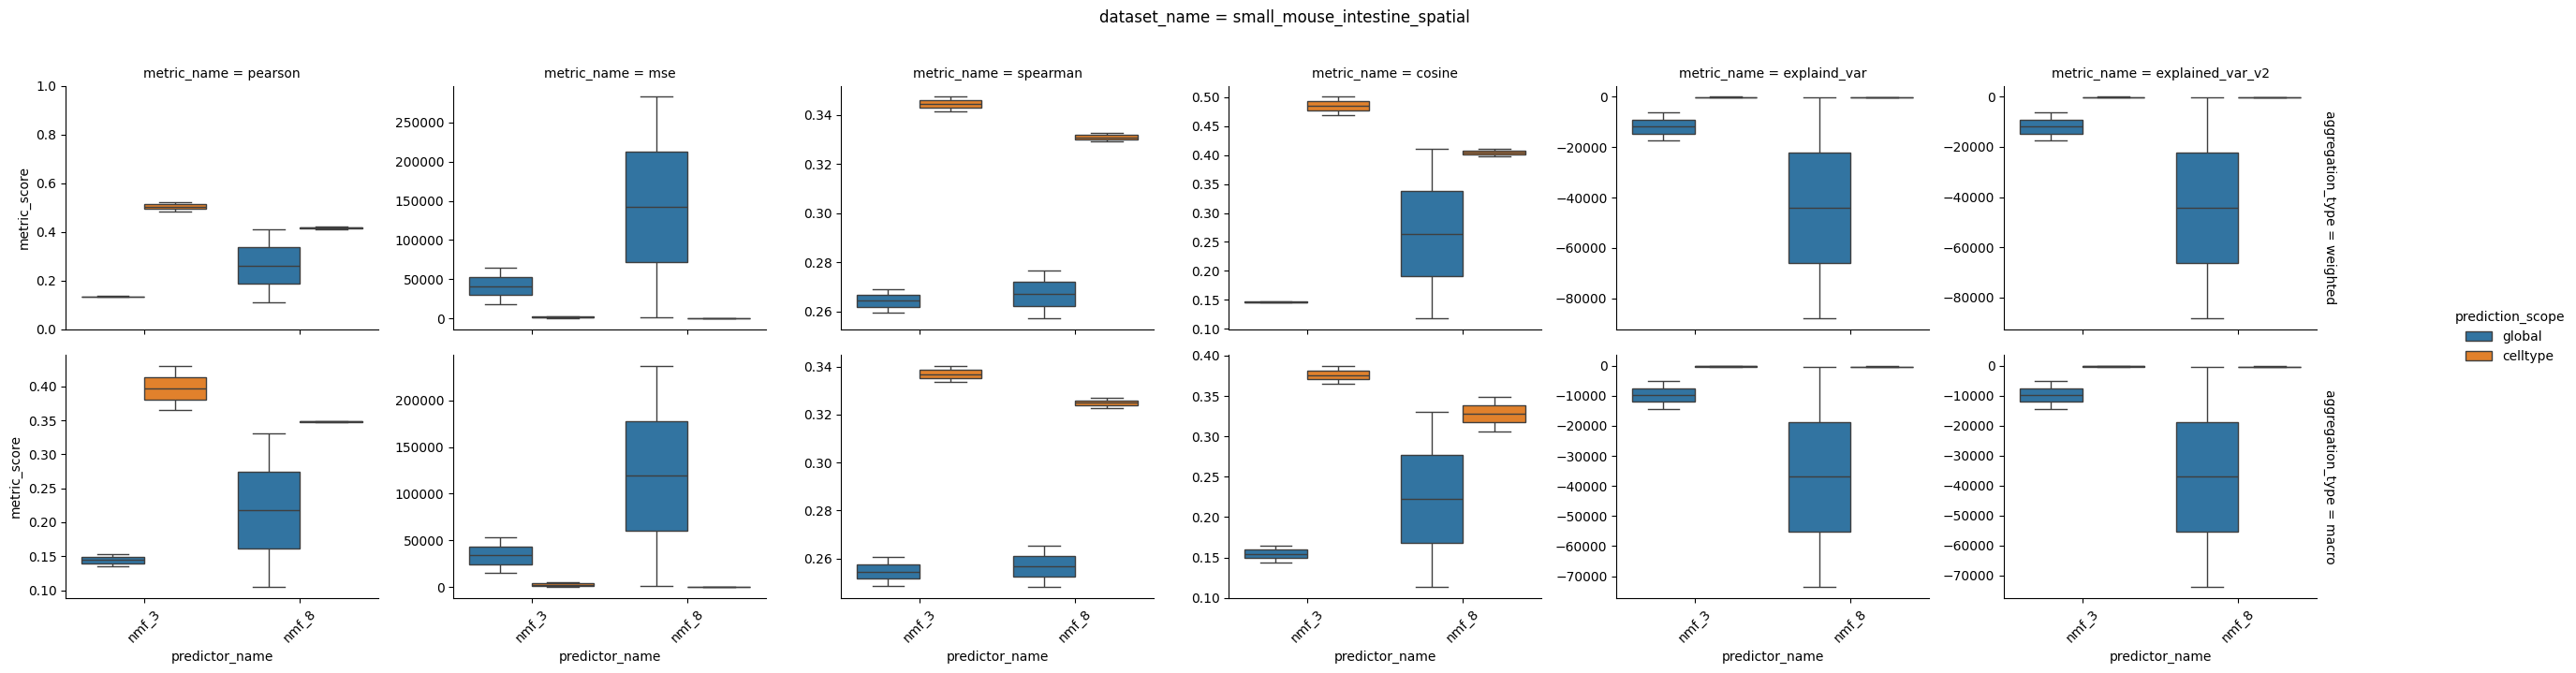

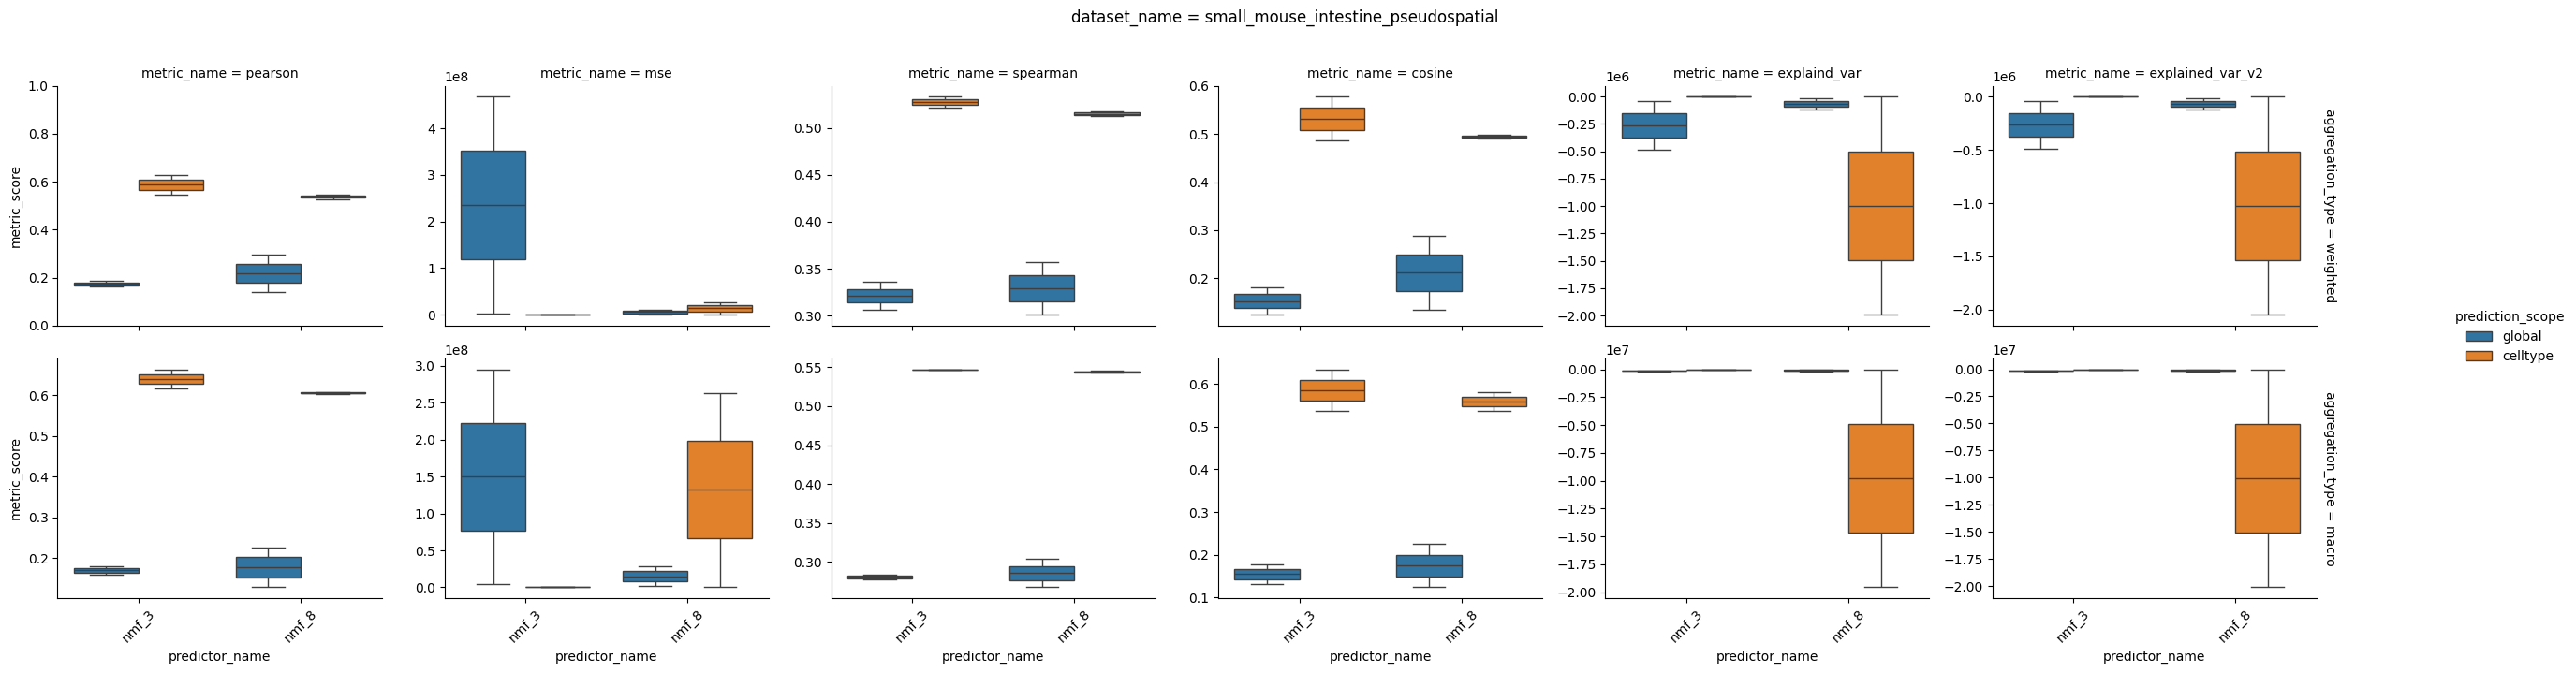

In [11]:
id_cols = ["dataset_name", "predictor_name", "prediction_scope", "aggregation_type"]
metric_cols = [c for c in df.columns if c not in id_cols]

plot_df = df.to_pandas().melt(
    id_vars=id_cols,
    value_vars=metric_cols,
    var_name="metric_name",
    value_name="metric_score",
)

for dataset_name in plot_df["dataset_name"].drop_duplicates():
    dataset_plot_df = plot_df[plot_df["dataset_name"] == dataset_name]

    g = sns.catplot(
        data=dataset_plot_df,
        kind="box",
        x="predictor_name",
        y="metric_score",
        hue="prediction_scope",
        row="aggregation_type",
        col="metric_name",
        sharey=False,
        height=3.5,
        aspect=1.25,
        margin_titles=True,
    )

    g.fig.suptitle(f"dataset_name = {dataset_name}", y=1.02)
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45)
        # ax.set_yscale("log")
        if ax.get_title().endswith("pearson"):
            ax.set_ylim(0, 1)
    g.tight_layout()



 ### Model Embeddings